# BBC News Classification: Unsupervised Learning VS Supervised Learning

I will utilize a publicly available dataset from the BBC, which can be accessed at https://www.kaggle.com/competitions/learn-ai-bbc/overview. This is a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech. My approach will involve applying Non-Negative Matrix Factorization(NMF) for topic modeling, followed by a supervised learning model for classification. The performance of these two methods will be compared to evaluate their effectiveness in text analysis.

## 1.Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

### Import Libraries


In [140]:
# basics
import numpy as np
import itertools
from itertools import permutations
import os

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Unsupervised learning
from sklearn.decomposition import NMF

# Supervised learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# helper functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
# disable ssl check for downloading some of the libraries
# https://stackoverflow.com/questions/38916452/nltk-download-ssl-certificate-verify-failed
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [16]:
# download data cleaning libraries
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/judoboyalex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/judoboyalex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/judoboyalex/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/judoboyalex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Data Overview

In [4]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        if not filename.startswith('.'):  # Skip hidden files
            print(os.path.join(dirname, filename))

./data/BBC News Train.csv
./data/BBC News Test.csv
./data/BBC News Sample Solution.csv


In [5]:
train_data = pd.read_csv('./data/BBC News Train.csv')
test_data = pd.read_csv('./data/BBC News Test.csv')
sample_data = pd.read_csv('./data/BBC News Sample Solution.csv')

In [6]:
print(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Initial look shows there are 3 columns(ArticleId, Text and Category) and 1490 rows.

In [7]:
train_data.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

There are no null values in this data, which makes it very easy to work with, since there is minimal work required for cleaning data.
Let's see if there are any duplicates in this data.

In [8]:
# Checking for duplicate entries
duplicate_texts = train_data['Text'].duplicated().sum()

print(f'Number of duplicate texts: {duplicate_texts}')
print('Example of duplicated article:')
train_data.iloc[[62, 157], :2]

Number of duplicate texts: 50
Example of duplicated article:


,ArticleId,Text
62,476,prince crowned top music earner prince earne...
157,853,prince crowned top music earner prince earne...


There are some clean up to do as there are duplicated articles, which need to be removed.

In [9]:
# Dropping duplicate entries
train_data = train_data.drop_duplicates(subset=['Text'])

# Checking the shape of the data after the duplicate entries were dropped
train_data.shape

(1440, 3)

After removing duplicates, now there are 1440 rows which makes sense since there were 50 duplicates found(1490-50 = 1440).
Let's check out how articles are distributed.

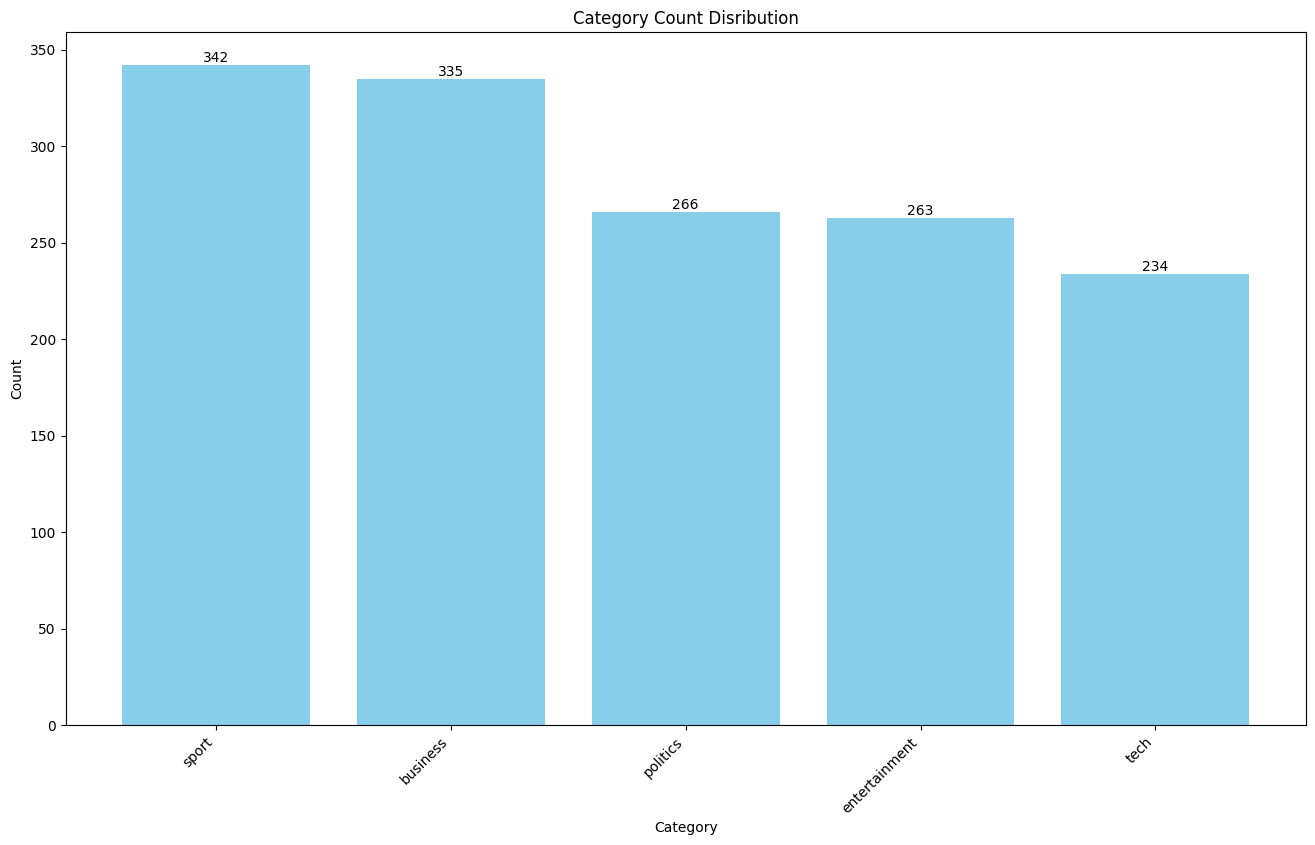

In [10]:
# Plot histogram of number of articles per category
category_counts = train_data['Category'].value_counts()
plt.figure(figsize=(16, 9))
plt.bar(category_counts.index, category_counts, color='skyblue')
plt.title('Category Count Disribution')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Count')
for i, count in enumerate(category_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

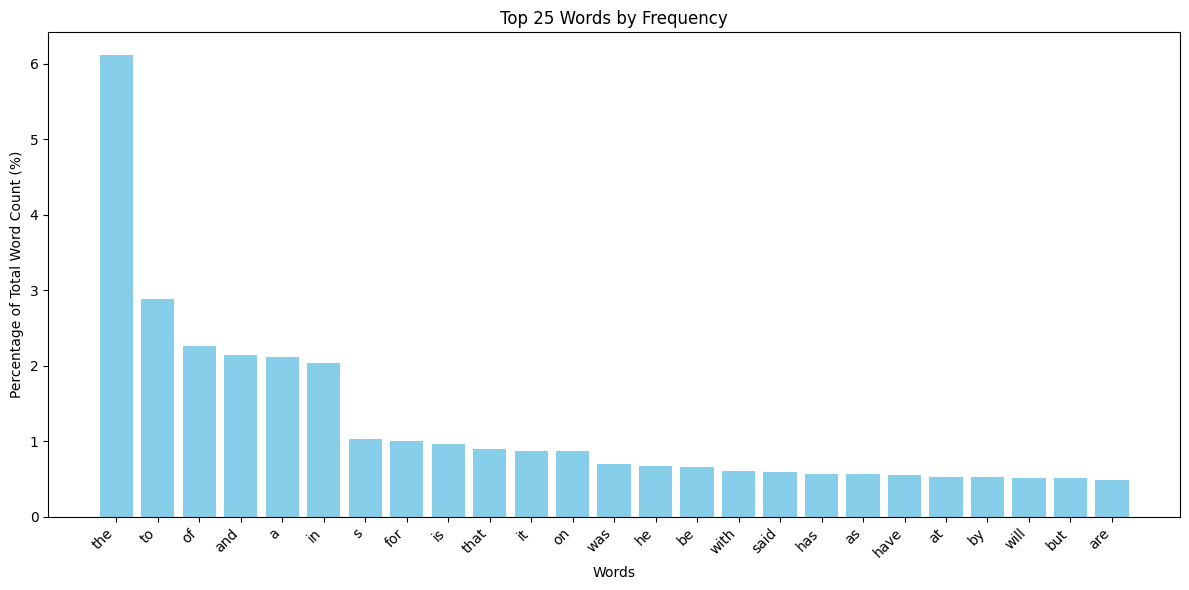

In [11]:
# Plot top 25 words by frequency
frequency = train_data['Text'].str.split(expand=True).unstack().value_counts()
freqplot = frequency[:25] / np.sum(frequency) * 100

plt.figure(figsize=(12, 6))
plt.bar(freqplot.index, freqplot.values, color='skyblue')
plt.title('Top 25 Words by Frequency')
plt.xlabel('Words')
plt.ylabel('Percentage of Total Word Count (%)')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

None of these words are meaningful word that can be categorized into certain categories. I'll use the help of libraries to extract key words.

### Data Preprocessing

Before extracting the features, cleaning up the data would be good idea.

In [99]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocessing_data(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove digits and punctuation using regex
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Return the processed text
    return ' '.join(tokens)

# Example usage for processing training data
processed_train_data = [preprocessing_data(data) for data in train_data['Text']]

Explanation of changes I made in above code:
Tokenization: word_tokenize from nltk splits the text into words.
Lemmatization: WordNetLemmatizer is used to lemmatize words.
Stopwords Removal: NLTK's stopwords corpus is used to filter out common stopwords.
Punctuation/Digit Removal: re.sub() is used to remove digits and punctuation.

In [100]:
# Print an example of the cleaned text
processed_train_data[0]

'worldcom exboss launch defence lawyer defending former worldcom chief bernie ebbers battery fraud charge called company whistleblower first witness cynthia cooper worldcom exhead internal accounting alerted director irregular accounting practice u telecom giant warning led collapse firm following discovery bn bn accounting fraud mr ebbers pleaded guilty charge fraud conspiracy prosecution lawyer argued mr ebbers orchestrated series accounting trick worldcom ordering employee hide expense inflate revenue meet wall street earnings estimate m cooper run consulting business told jury new york wednesday external auditor arthur andersen approved worldcom accounting early said andersen given green light procedure practice used worldcom mr ebber lawyer said unaware fraud arguing auditor alert problem m cooper also said shareholder meeting mr ebbers often passed technical question company finance chief giving brief answer prosecution star witness former worldcom financial chief scott sullivan 

Texts are looking clean and ready for feature extraction.

### Feature Extraction

In order to analysis my dateset with Machine Learning methods, I need to transform each article's text to a feature vector. Use the TF-IDF (Term Frequency-Inverse Document Frequency) to capture the importance of words within a document and across the entire dataset. This will creates a document-term matrix where rows represent documents and columns represent unique words.

In [118]:
tfidf_vectorizer = TfidfVectorizer(max_df=.95, min_df=2, stop_words='english')
features = tfidf_vectorizer.fit_transform(processed_train_data) # Decided not to use processed_train_data here as accuracy was worse with cleaned data. My guess is I over-cleaned
feature_names = tfidf_vectorizer.get_feature_names_out()
features.shape

(1440, 12140)

## 2.Building and Training Models

### Unsupervised Learning: Non-Negative Matrix Factorization Models

NMF model is suitable for our Text/word counts data with non-negative entries.
I will start off with an NMF model that has Frobenius loss as the objective function.
Later, I will tune up hyperparameters to find out the best parameter that outputs the most accuracy.

In [124]:
model_nmf = NMF(n_components=5, init='nndsvd', beta_loss='frobenius', solver='cd', max_iter=200).fit(features)
W = model_nmf.transform(features)
H = model_nmf.components_

Let's identify the most important words by category by comparing the result with graphs.

In [125]:
def plot_top_features(H, feature_names):
    plt.figure(figsize=(24, 16))
    for i, topic in enumerate(H):
        plt.subplot(231+i)
        top_features_ind = topic.argsort()[-20:]
        top_features_names = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        plt.barh(top_features_names, weights, height=0.7)
        plt.yticks(fontsize=16)
        plt.title(f'Topic {i+1}', fontsize=24)
    plt.tight_layout()

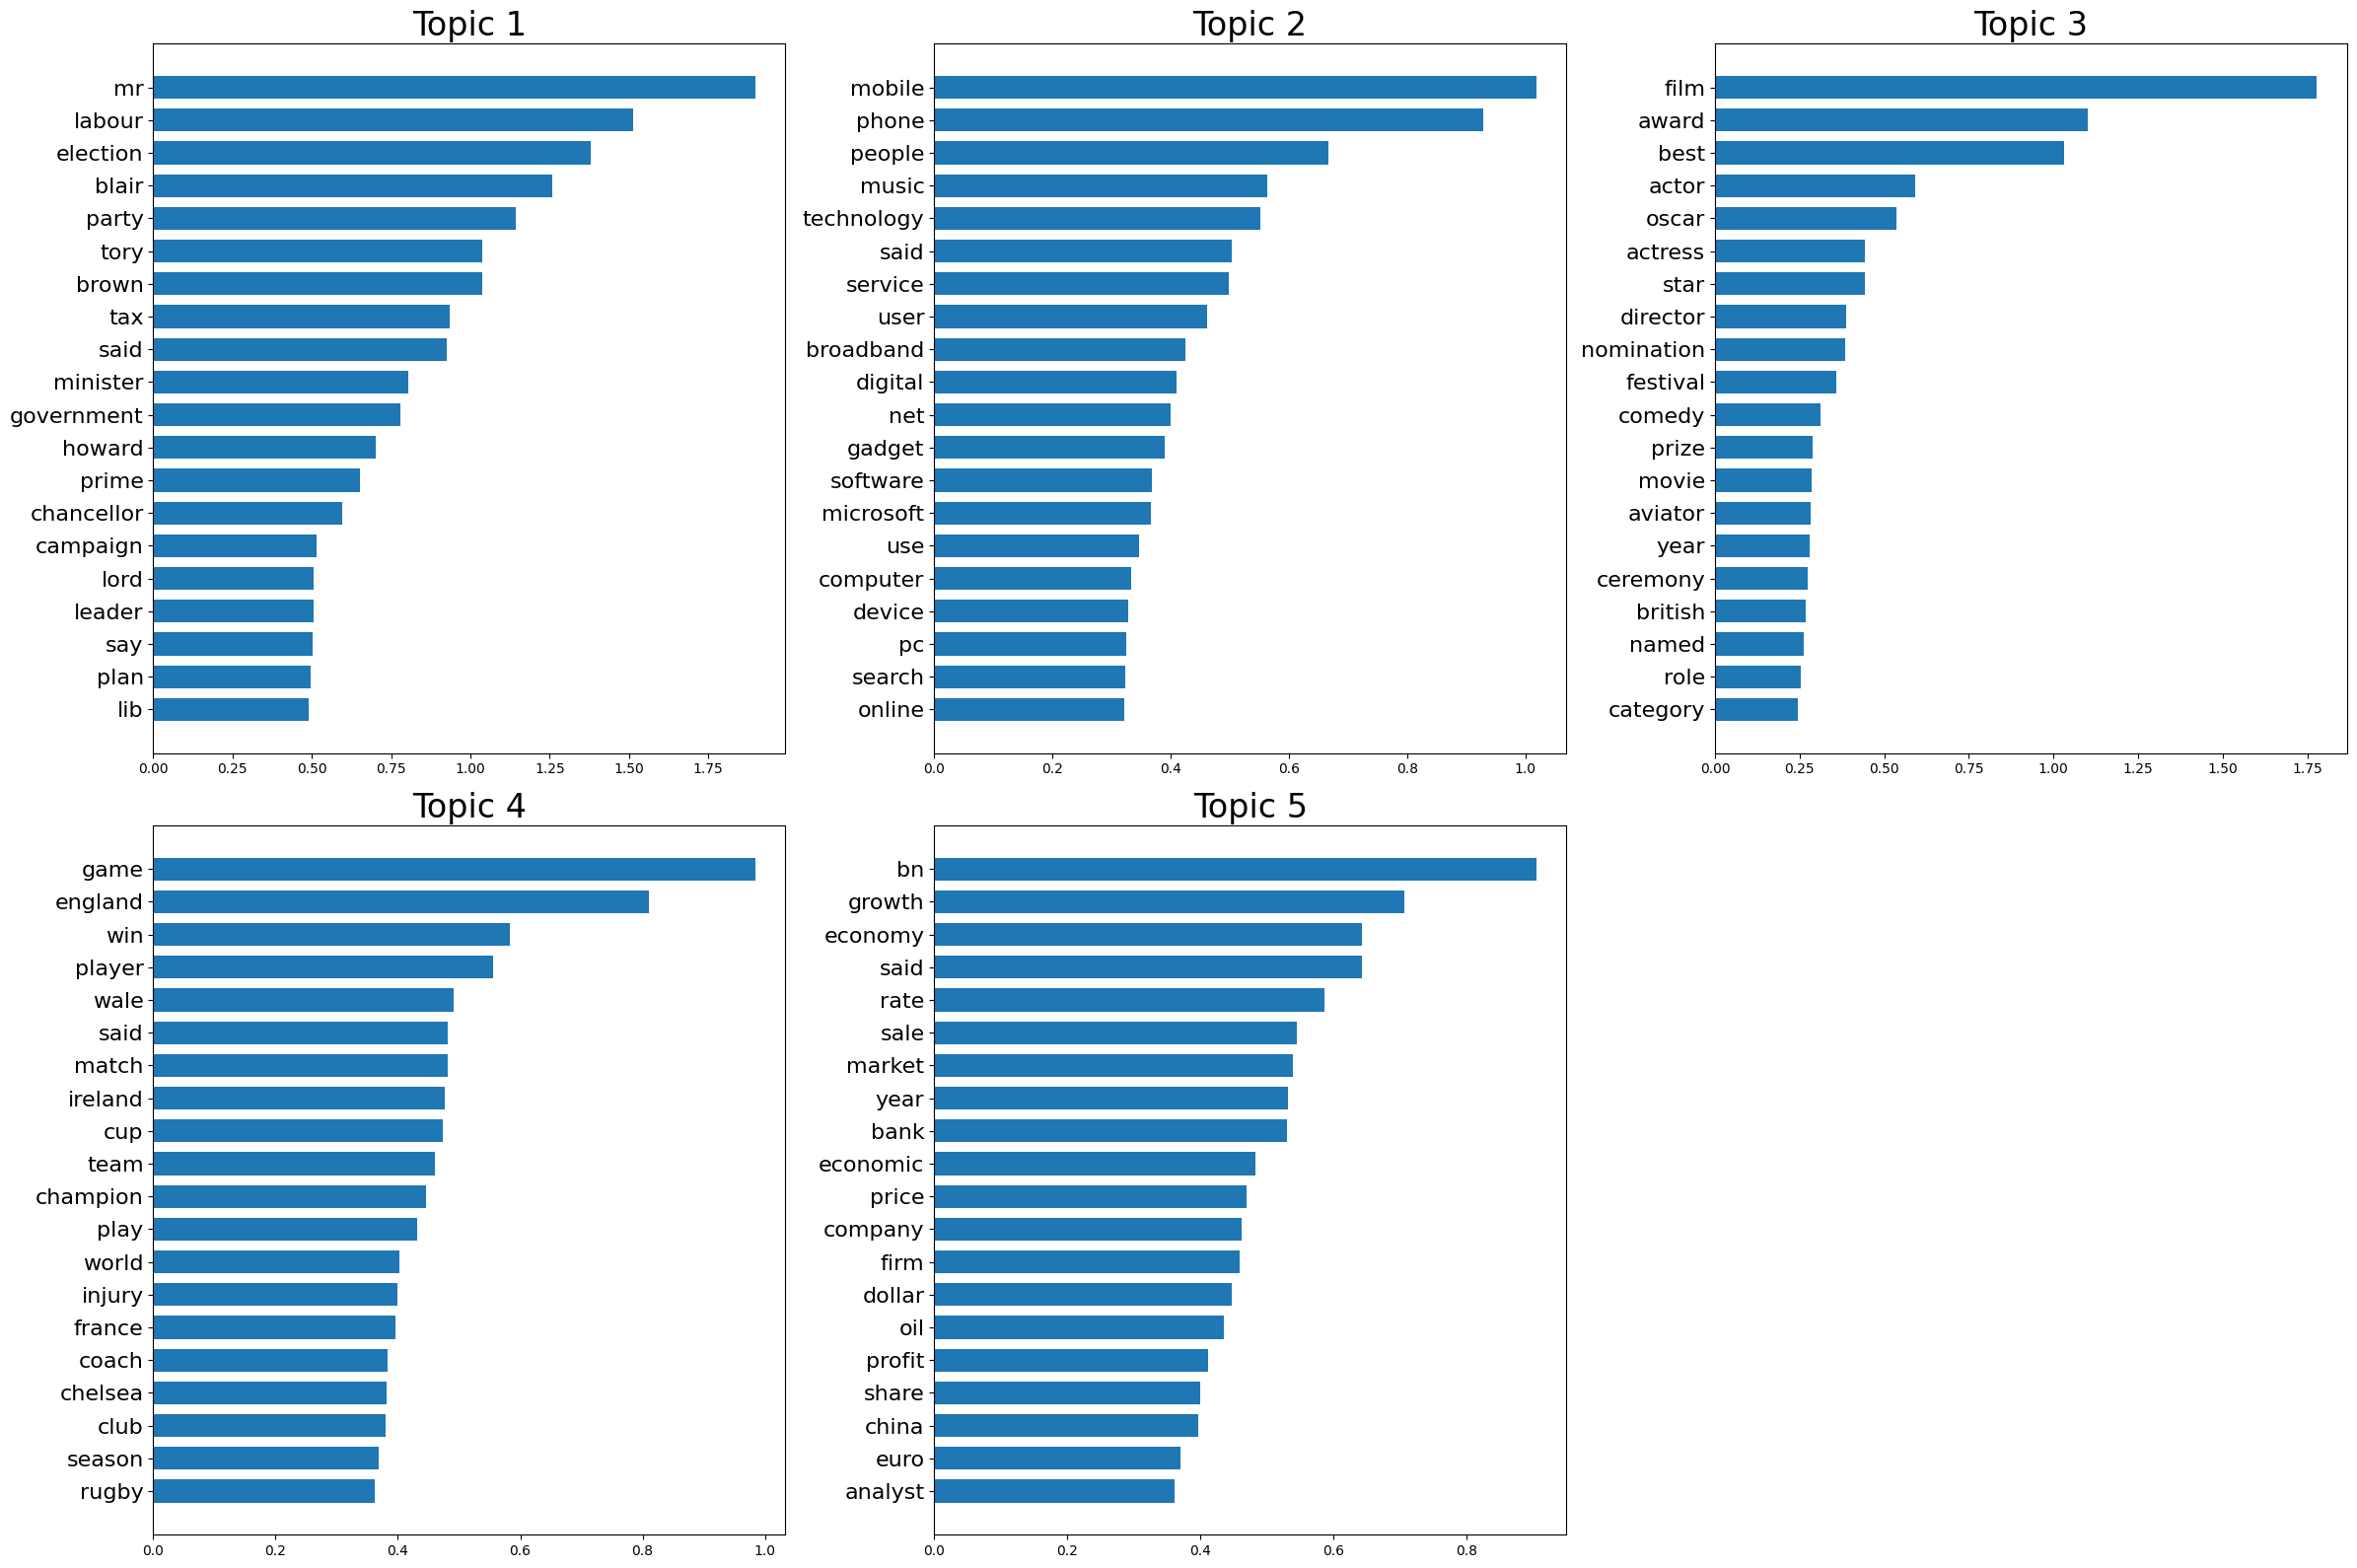

In [126]:
plot_top_features(H, feature_names)

As the graphs show, it's easier to identify which topic belongs to which category. For example, Topic 4 falls under Sports category since its top words are "game", "win", "player".
Now, let's checkout performance of NMF model.

In [127]:
label_names = train_data.Category.unique().tolist()
mapping = dict(zip(label_names, list(range(5))))
train_data['labels'] = [mapping[c] for c in train_data.Category]

y = train_data.labels.tolist()
predictions = np.argmax(W, axis=1)

BEST_ORDERING = None

def label_permute_compare(y, yp):  
    unique_labels = np.unique(yp)
    ordering = permutations(unique_labels)    
    best_accuracy = 0.0
    global BEST_ORDERING
    
    for order in ordering:
        # Create a mapping of yp according to order
        label_mapping = dict(zip(unique_labels, order))
        reordered_yp = np.array([label_mapping[lbl] for lbl in yp])
        
        curr_score = accuracy_score(y, reordered_yp)
        if curr_score > best_accuracy:
            best_accuracy = curr_score
            BEST_ORDERING = order
            
    return best_accuracy

In [128]:
print('Accuracy score for NMF model with beta_loss="frobenius":')
label_permute_compare(y, predictions)

Accuracy score for NMF model with beta_loss="frobenius":


0.9069444444444444

With 0.9069 accuracy, NMF performed very well. 
Now, I'll tune up hyperparameters to see if I can produce better performance.

Trying combination: {'n_components': 5, 'solver': 'mu', 'init': 'random', 'beta_loss': 'frobenius', 'l1_ratio': 0, 'max_iter': 200}
Trying combination: {'n_components': 5, 'solver': 'mu', 'init': 'random', 'beta_loss': 'frobenius', 'l1_ratio': 0.5, 'max_iter': 200}
Trying combination: {'n_components': 5, 'solver': 'mu', 'init': 'random', 'beta_loss': 'frobenius', 'l1_ratio': 1, 'max_iter': 200}
Trying combination: {'n_components': 5, 'solver': 'mu', 'init': 'random', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0, 'max_iter': 200}
Trying combination: {'n_components': 5, 'solver': 'mu', 'init': 'random', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.5, 'max_iter': 200}
Trying combination: {'n_components': 5, 'solver': 'mu', 'init': 'random', 'beta_loss': 'kullback-leibler', 'l1_ratio': 1, 'max_iter': 200}
Trying combination: {'n_components': 5, 'solver': 'mu', 'init': 'nndsvd', 'beta_loss': 'frobenius', 'l1_ratio': 0, 'max_iter': 200}
Trying combination: {'n_components': 5, 'solver': '

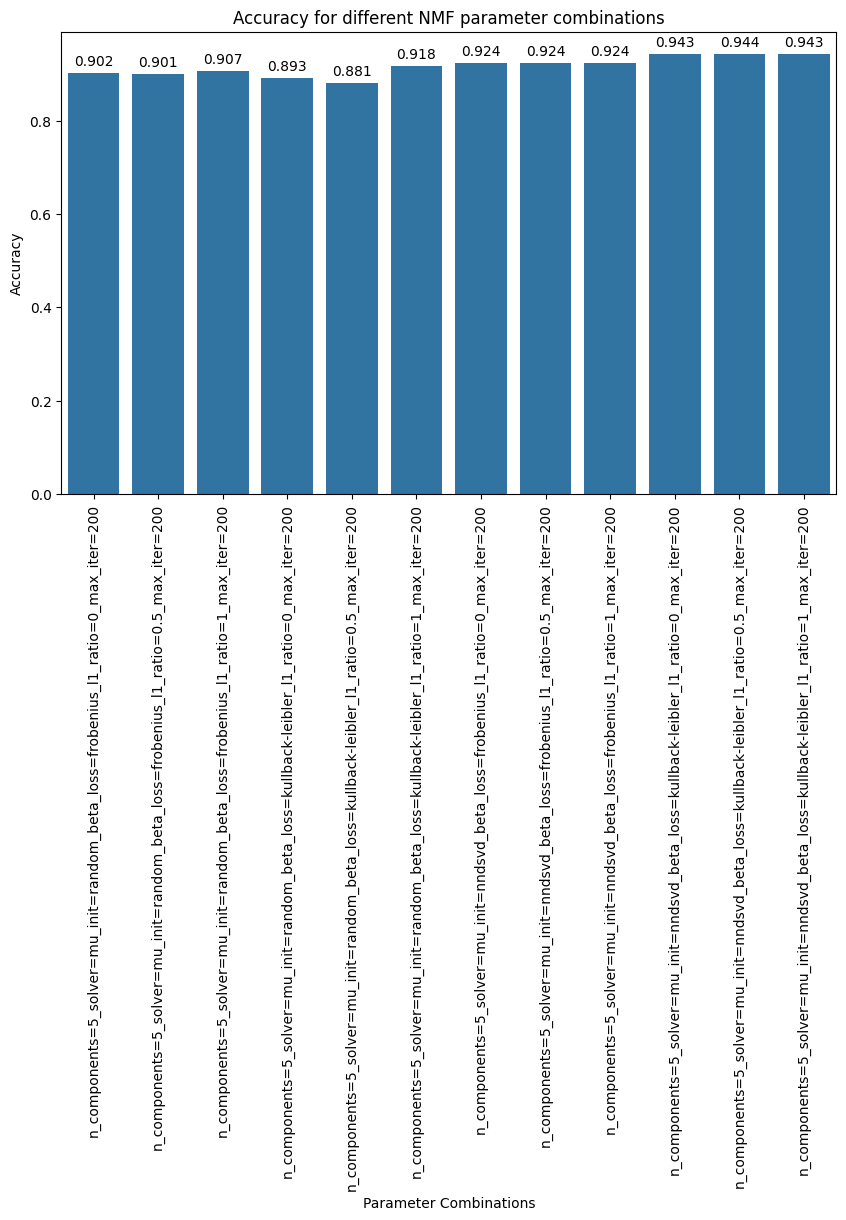

In [136]:
import warnings

# Suppress UserWarnings from sklearn
warnings.filterwarnings('ignore')

# Function to perform grid search on NMF model and return best parameters and accuracy
def grid_search_nmf(features, y, param_grid):
    # List to store results
    results = []
    
    # Generate all combinations of parameters
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    best_accuracy = 0
    best_params = None
    
    # Iterate over each combination of parameters
    for params in combinations:
        print(f"Trying combination: {params}")
        
        # Train NMF model with current set of parameters
        model_nmf = NMF(n_components=params['n_components'], 
                        init=params['init'], 
                        beta_loss=params['beta_loss'], 
                        solver=params['solver'], 
                        l1_ratio=params['l1_ratio'], 
                        max_iter=params['max_iter']).fit(features)
        
        W = model_nmf.transform(features)
        predictions = np.argmax(W, axis=1)
        
        # Calculate accuracy
        accuracy = label_permute_compare(y, predictions)
        results.append((params, accuracy))
        
        # Check if this is the best accuracy so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params
            
    return best_params, best_accuracy, results

# Run the grid search
param_grid = {
    'n_components': [5],
    'solver': ['mu'],
    'init': ['random', 'nndsvd'],
    'beta_loss': ['frobenius', 'kullback-leibler'],
    'l1_ratio': [0, 0.5, 1],
    'max_iter': [200]
}

best_params, best_accuracy, results = grid_search_nmf(features, y, param_grid)

# Print best results
print("")
print(f"Best accuracy: {best_accuracy}")
print(f"Best parameters: {best_params}")

# Prepare data for plotting
params_list = ['_'.join([f"{key}={value}" for key, value in params.items()]) for params, _ in results]
accuracy_list = [acc for _, acc in results]

# Plot the accuracy results for each combination
plt.figure(figsize=(10, 6))
ax=sns.barplot(x=params_list, y=accuracy_list)
plt.xticks(rotation=90)
# Add the accuracy value at the top of each bar
for i, acc in enumerate(accuracy_list):
    ax.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', fontsize=10)
plt.xlabel('Parameter Combinations')
plt.ylabel('Accuracy')
plt.title('Accuracy for different NMF parameter combinations')
plt.tight_layout()
plt.show()

With tune up, the result shows beta loss of 'kullback-leibler' tend to output more accurately as the best result is 0.944, which is significant improvement from 0.90.

##  3.Compare With Supervised Learning
I have picked Logistic Regression and Random Forest to compare against NMF model.
Let's start with Logistic Regression.

In [137]:
# Create y_train from the provided training data
y_train = train_data['Category']

# Logistic regression model
log_reg = LogisticRegression(max_iter=1000).fit(features, y_train)

y_train_pred = log_reg.predict(features)

lr_train_acc = accuracy_score(y_train, y_train_pred)

print(f'Logistic Regression Training Accuracy: {lr_train_acc}')

Logistic Regression Training Accuracy: 0.9972222222222222


Logistic regression blows off the competition with extreme accuracy of 0.997.

In [139]:
# random forest
rf= RandomForestClassifier()

# grid search for rf
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [20, 50],
    'min_samples_split': [10,20],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(features, train_data['Category'])

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_rf_model = grid_search.best_estimator_
print(f'Random Forest Training Accuracy: {grid_search.best_score_}')
print(f"Best parameters: {best_params}")

0.9562499999999999
Random Forest Training Accuracy: 0.9562499999999999
Best parameters: {'max_depth': 50, 'min_samples_split': 10, 'n_estimators': 50}


Not bad performance by Random Forest with 0.956 although I was expecting it to produce somewhere around 0.97.
It could be deep tree(max_depth=50) that resulted in overfitting while `n_estimators` is too few, leading to an unstable prediction.
Regardless, both supervised learning model performed better than NMF.
Let's now compare how they perform in different data set sizes(50%, 20%, 10%).

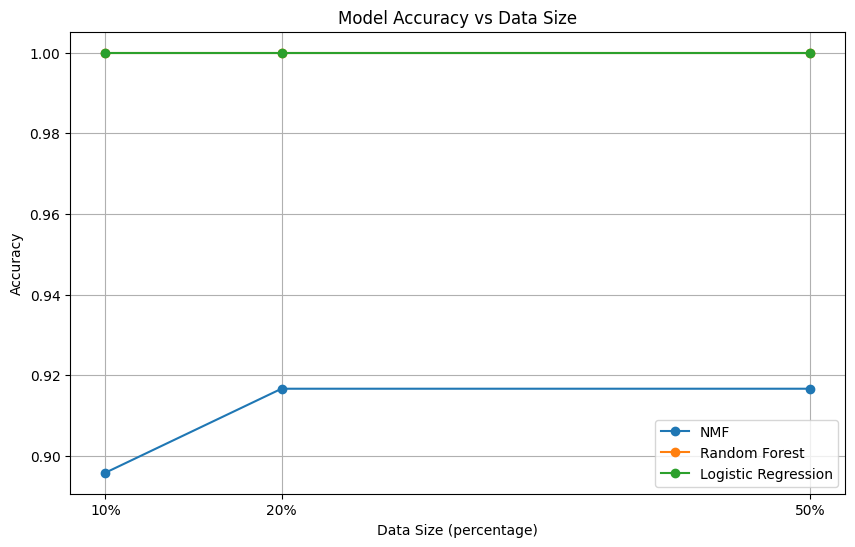

In [147]:
# Define RandomForest model with the given parameters
rf_model = RandomForestClassifier(max_depth=50, min_samples_split=10, n_estimators=50, random_state=42)

# Prepare data size percentages
data_sizes = [0.5, 0.2, 0.1]
nmf_accuracies = []
rf_accuracies = []
lr_accuracies = []

for size in data_sizes:
    # Split data for each size
    X_train, _, y_train, _ = train_test_split(features, y, train_size=size, random_state=42)
    
    # NMF
    model_nmf = NMF(n_components=5, init='nndsvd', beta_loss='kullback-leibler', solver='mu', max_iter=200)
    W_train = model_nmf.fit_transform(X_train)
    nmf_preds = np.argmax(W_train, axis=1)
    nmf_acc = label_permute_compare(y_train, nmf_preds)
    nmf_accuracies.append(nmf_acc)
    
    # Random Forest
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_train)
    rf_acc = accuracy_score(y_train, rf_preds)
    rf_accuracies.append(rf_acc)

    # Logistic Regression
    log_reg = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    lr_preds = log_reg.predict(X_train)
    lr_acc = accuracy_score(y_train, lr_preds)
    lr_accuracies.append(lr_acc)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, nmf_accuracies, label='NMF', marker='o')
plt.plot(data_sizes, rf_accuracies, label='Random Forest', marker='o')
plt.plot(data_sizes, lr_accuracies, label='Logistic Regression', marker='o')

# Add titles and labels
plt.title('Model Accuracy vs Data Size')
plt.xlabel('Data Size (percentage)')
plt.ylabel('Accuracy')
plt.xticks(data_sizes, ['50%', '20%', '10%'])
plt.legend()
plt.grid(True)

# Display the chart
plt.show()

It is clear that NMF perform poorly as training data size decreases while supervised learning model like Logistic Regression performed superbly even with smaller data set.

NMF is an unsupervised learning method, meaning it does not directly learn from labeled data (i.e., it doesn't use the target values during training). It simply reduces the dimensionality of the input data by factorizing it into two matrices: one for latent features (W) and one for the basis components (H).
On the other hand, Logistic Regression is a supervised learning model that explicitly learns the mapping from features to the target (labels) using the ground-truth labels during training. This allows Logistic Regression to make more informed predictions.
With only 10% of the data, the lack of label guidance in NMF makes it harder for the model to effectively learn useful representations, while Logistic Regression benefits from the labeled data to directly optimize classification performance.

In conclusion, in small datasets like 10%, Logistic Regression is more effective because:
- It leverages labeled data to directly learn a classification model.
- It can be regularized to prevent overfitting.
- It is less dependent on the discovery of latent structures, which are harder to extract in small datasets.

On the other hand, NMF struggles because:
- It is unsupervised and doesn't use the labels for optimization.
- It requires more data to learn meaningful low-rank representations.
- It may overfit or fail to capture useful information from small datasets, leading to poorer performance.

## 4.References

- Problem-solving with ML: automatic document classification
https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification
- Scikit-learn API Reference
https://scikit-learn.org/stable/modules/classes.html
- Vector 5 TF IDF - From Languages to Information
https://www.youtube.com/watch?v=TBUpxFw8oIA
- Work inspired
https://www.kaggle.com/code/jieshends2020/matrix-factorization-97-acc-with-1-labels
